# Bayesian Changepoint Detection for Stepwise Datasets 

This code computes the probability of changepoints in a time series.In this notebook example, I show you how to use it.


In [1]:
from __future__ import division
import os
import numpy as np
import matplotlib.pyplot as plt

from bayesian_changepoint_detection.stepwise_change_functions import *

from bayesian_changepoint_detection.priors import const_prior
from functools import partial

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

from bayesian_changepoint_detection.x_index_averager import average_indices

%matplotlib widget

Use scipy logsumexp().


First let's generate some toy-data:

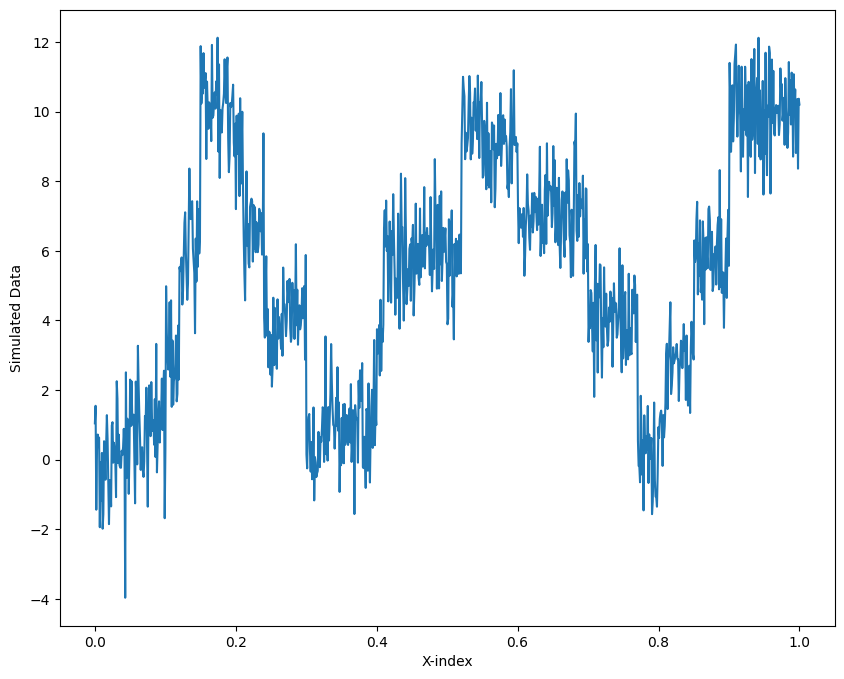

In [2]:
# Generate step-like traces
n_points = 1000
step_locs = [0.05, 0.1, 0.12, 0.15, 0.2, 0.21, 0.24, 0.3, 0.32, 0.4, 0.41, 0.52, 0.55, 0.6, 0.7, 0.77, 0.8, 0.81, 0.85, 0.9]
step_sizes = [1, 2, 3, 4, -1, -2, -3, -4, 1, 2, 3, 4, -1, -2, -3, -4, 1, 2, 3, 4]
# step_sizes = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

# You can tune the noise level to better simulate your real data
noise_std = 1

x, data = generate_step_data(n_points, step_locs, step_sizes, noise_std)

plt.figure(figsize=(10,8))
plt.xlabel('X-index')
plt.ylabel('Simulated Data')
plt.plot(x,data)
plt.show()

## Bayesian Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

Compute the likelihood of changepoints on data. `offline_changepoint_detection()`

    Parameters:
    Inputs:
        data    -- the time series data
        truncate  -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood

    Outputs:
        P  -- the log-likelihood of a datasequence [t, s], given there is no changepoint between t and s
        Q -- the log-likelihood of data
        Pcp --  the log-likelihood that the i-th changepoint is at time step t. To actually get the probility of a changepoint at time step t sum the probabilities.

The `offline_changepoint_detection()` function returns three things: `Q[t]`, the log-likelihood of data `[t, n]`, `P[t, s]`, the log-likelihood of a datasequence `[t, s]`, given there is no changepoint between `t` and `s` and `Pcp[i, t]`, the log-likelihood that the `i`-th changepoint is at time step `t`. To actually get the probility of a changepoint at time step `t` sum the probabilities.

In [3]:
# Let's start to analyze the trace

prior_function = partial(const_prior, p=1/(len(data) + 1))
Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-50)

How does that look like for our toy-data?

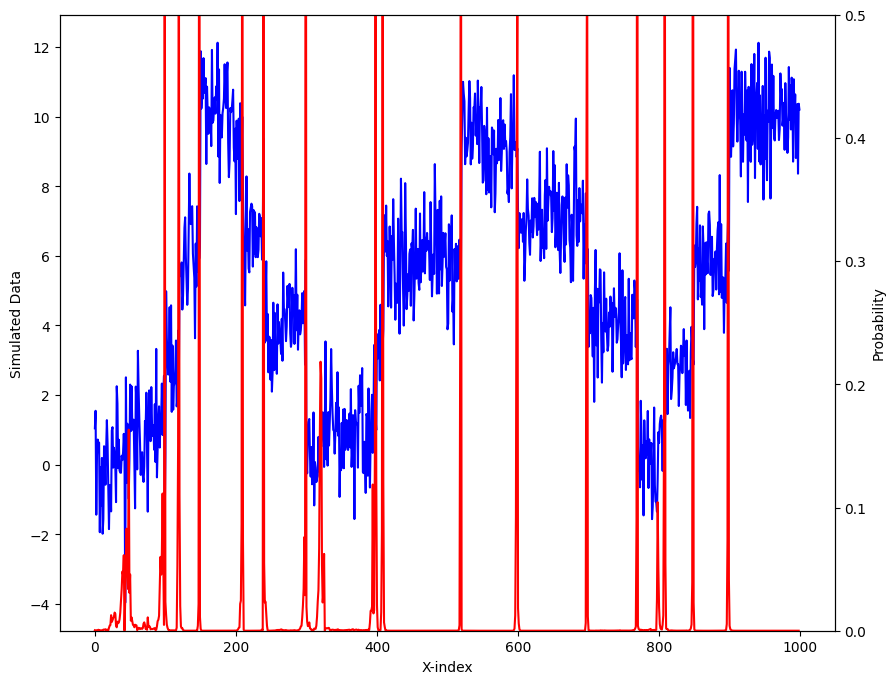

In [4]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot the data
ax1.plot(data[:], color='blue')
ax2.plot(np.exp(Pcp).sum(0), color='red')

# Set the y-limits for the second axis
ax2.set_ylim(0,0.5)

# Set the x-label and y-label for the first axis
ax1.set_xlabel('X-index')
ax1.set_ylabel('Simulated Data')

# Set the y-label for the second axis
ax2.set_ylabel('Probability')

# Show the plot
plt.show()

Before proceeding to further analysis, we need to filter those less probably based on our domain knowledge. We can tune the filter with two parameters. `prob_threshold` and `closeness_threshold`.
- `prob_threshold`: sets a threshold, only above which is considered as a real change-point; normally 0.1-0.2 works good. 
- `closeness_threshold`: sets a threshold, only wider than which is considered a new change-point, otherwise will be grouped and averaged into the previous one. 

In [7]:
# set your threshold here
prob_threshold = 0.1
closeness_threshold = 10

averaged_indices = average_indices(prob_threshold, closeness_threshold, Pcp)

# for index in averaged_indices:
#     print(index)

print(averaged_indices)

[48, 98, 119, 148, 209, 239, 299, 320, 401, 518, 598, 698, 769, 804, 848, 898]


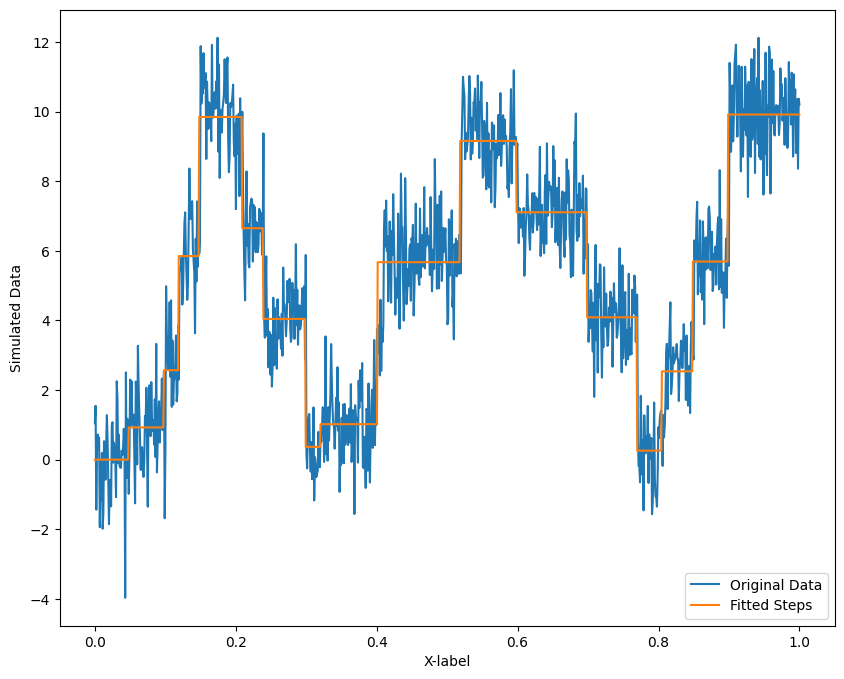

In [6]:
# Recalculate step sizes based on the optimal step locations
recalculated_step_sizes = recalculate_step_sizes(data[:], averaged_indices)

# Reconstruct and plot the fitted curve
fitted_curve = reconstruct_fitted_curve(x, data, averaged_indices, recalculated_step_sizes)

# Plot the origianl data
plt.figure(figsize=(10,8))
plt.plot(x, data, label="Original Data")
plt.plot(x, fitted_curve, label="Fitted Steps")
plt.xlabel('X-label')
plt.ylabel('Simulated Data')
plt.legend()
plt.show()

That works pretty well, but is somewhat slow. It's possible to speed that up by truncating a sum in the algorithm. However that sometimes leeds to $\infty$ values. Set the `truncate` parameter to e.g. `-10` to test that out.

Now let's save save the output data (like the location of steps, step-size, and plateau length) to the "Test_Outputdata" folder for further analysis: 

In [12]:
# calculate the date
step_locations = np.concatenate([[x[0]], x[averaged_indices], [x[-1]]])
step_sizes = recalculated_step_sizes
plateau_lengths = np.diff(step_locations)

# Saving the extracted information
output_directory = 'Test_Outputdata'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save step locations, step-sizes, and plateau lengths to files
np.savetxt(os.path.join(output_directory, 'stepwise_step_locations.txt'), step_locations)
np.savetxt(os.path.join(output_directory, 'stepwise_step_sizes.txt'), step_sizes, fmt='%.5f')
np.savetxt(os.path.join(output_directory, 'stepwise_plateau_lengths.txt'), plateau_lengths)